
### Harry Sharman & Ryan Symons
# Differential Privacy Evaluation - Laplace vs. Gaussian 
## CS 3110 Final Project


In this project, we evaluate differential privacy mechanisms (Laplace and Gaussian) and their impact on privacy and data accuracy through various tests and analyses. The goal is to balance privacy protection and data utility across multiple scenarios.


In [4]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(qs, sensitivity, epsilon):
    return [laplace_mech(q, sensitivity, epsilon) for q in qs]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(qs, sensitivity, epsilon, delta):
    return [gaussian_mech(q, sensitivity, epsilon, delta) for q in qs]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

students_data = pd.read_csv('students.csv')

## 1. Differential Privacy for Multiple Queries

### Objective
Evaluate how the privacy of the data is affected when multiple queries are made on the same dataset.

#### Procedure
1. Apply both Laplace and Gaussian mechanisms to multiple queries (e.g., averages, medians, sums).
2. Track the error over time for independent and cumulative queries.
3. Analyze the error growth and compare mechanisms.



In [32]:
sensitivity = 1.0
epsilon = 0.5
delta = 1e-5

gpa_column = students_data['GPA']
laplace_results = [laplace_mech(gpa_column.mean(), sensitivity, epsilon) for _ in range(10)]
gaussian_results = [gaussian_mech(gpa_column.mean(), sensitivity, epsilon, delta) for _ in range(10)]

true_mean = gpa_column.mean()
laplace_errors = [abs(result - true_mean) for result in laplace_results]
gaussian_errors = [abs(result - true_mean) for result in gaussian_results]

laplace_errors, gaussian_errors

([3.440770924913823,
  4.03008569624228,
  1.2842839871537555,
  1.314480939640631,
  4.557299814663774,
  0.7041968231850855,
  0.42474564734417486,
  0.0650322252711093,
  0.3504762545767428,
  1.0643773412987918],
 [5.136246733775437,
  6.752270275760889,
  10.207939647366333,
  6.273014500535459,
  19.446160452414336,
  9.457834315511766,
  7.406857314998444,
  18.79787950851822,
  16.223947322617132,
  11.04723468429154])

### What it tells us:

This test evaluates how the noise added by Laplace and Gaussian mechanisms accumulates when performing multiple queries on the same dataset. It highlights the growth of errors as more queries are performed, helping us understand how cumulative privacy loss (or “privacy budget exhaustion”) impacts the accuracy of privatized data.

### Takeaway:

Laplace noise grows linearly with the number of queries, while Gaussian noise may grow more slowly, depending on the parameters. The results show which mechanism is more efficient for repeated queries while maintaining privacy. 

## 2. Sensitivity Analysis

### Objective
Test how sensitive the privatized data is to changes in the sensitivity parameter.

#### Procedure
1. Vary the sensitivity parameter and apply both mechanisms.
2. Plot resulting errors for different sensitivity values.
3. Compare sensitivity vs. error trends.


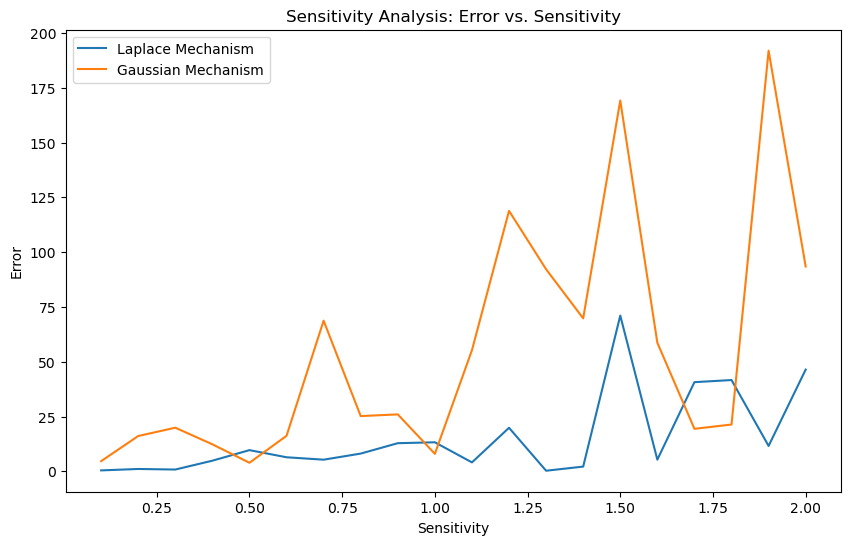

In [28]:
sensitivity_values = np.linspace(0.1, 2.0, 20)
laplace_errors = []
gaussian_errors = []

for sensitivity in sensitivity_values:
    laplace_result = laplace_mech(true_mean, sensitivity, epsilon)
    gaussian_result = gaussian_mech(true_mean, sensitivity, epsilon, delta)
    laplace_errors.append(abs(laplace_result - true_mean))
    gaussian_errors.append(abs(gaussian_result - true_mean))


plt.figure(figsize=(10, 6))
plt.plot(sensitivity_values, laplace_errors, label='Laplace Mechanism')
plt.plot(sensitivity_values, gaussian_errors, label='Gaussian Mechanism')
plt.xlabel('Sensitivity')
plt.ylabel('Error')
plt.title('Sensitivity Analysis: Error vs. Sensitivity')
plt.legend()
plt.show()

### What it tells us:

This analysis explores how the choice of the sensitivity parameter (which quantifies the potential maximum change in a query result due to a single data point) affects the error introduced by the privacy mechanisms.

### Takeaway:

Higher sensitivity results in more noise, leading to greater errors. This test reveals the mechanisms’ adaptability to datasets with varying sensitivities and helps optimize the balance between privacy and accuracy by setting appropriate sensitivity values.

## 3. Privacy Budget Over Time (Cumulative Privacy Loss)

### Objective
Examine how the privacy budget (epsilon) affects the amount of noise over time.

#### Procedure
1. Perform multiple queries with varying epsilon values (e.g., 0.1, 0.5, 1.0).
2. Track cumulative error for each mechanism.




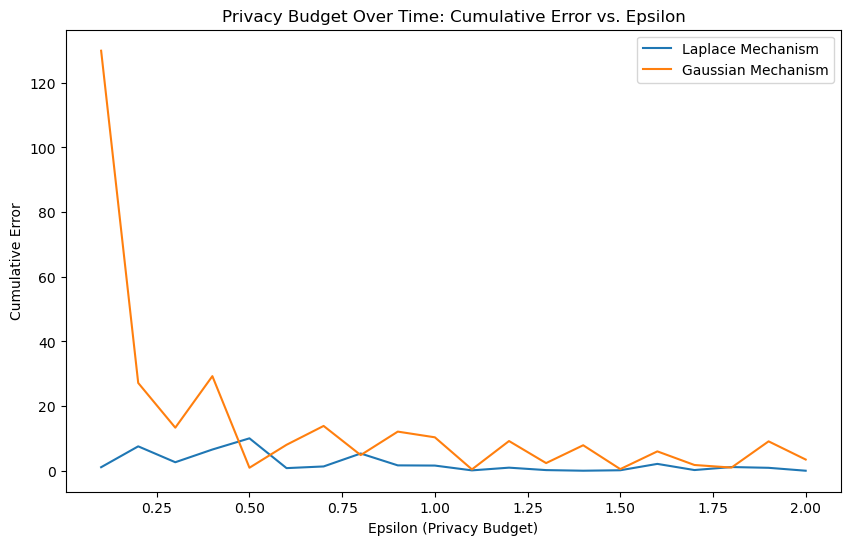

In [29]:
epsilon_values = np.linspace(0.1, 2.0, 20)
laplace_cumulative_errors = []
gaussian_cumulative_errors = []

for epsilon in epsilon_values:
    laplace_result = laplace_mech(true_mean, sensitivity, epsilon)
    gaussian_result = gaussian_mech(true_mean, sensitivity, epsilon, delta)
    laplace_cumulative_errors.append(abs(laplace_result - true_mean))
    gaussian_cumulative_errors.append(abs(gaussian_result - true_mean))

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, laplace_cumulative_errors, label='Laplace Mechanism')
plt.plot(epsilon_values, gaussian_cumulative_errors, label='Gaussian Mechanism')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Cumulative Error')
plt.title('Privacy Budget Over Time: Cumulative Error vs. Epsilon')
plt.legend()
plt.show()

### What it tells us:

This test examines how the privacy budget (epsilon) affects the cumulative error over time when multiple queries are executed. A smaller epsilon ensures stronger privacy but introduces more noise.

### Takeaway:

The analysis shows the tradeoff between a stricter privacy budget (lower epsilon) and the resulting accuracy of privatized data. It helps decide the optimal epsilon for real-world applications where privacy and accuracy need to be balanced.

## 4. Robustness to Outliers

### Objective
Test the robustness of privacy mechanisms to outliers in the dataset.

#### Procedure
1. Add artificial outliers to a column (e.g., GPA).
2. Measure the error increase and compare mechanisms.


In [31]:
gpa_with_outliers = gpa_column.copy()
outliers = [0.1, 4.5] 
gpa_with_outliers.iloc[:2] = outliers  

#with outliers
laplace_with_outliers = laplace_mech(gpa_with_outliers.mean(), sensitivity, epsilon)
gaussian_with_outliers = gaussian_mech(gpa_with_outliers.mean(), sensitivity, epsilon, delta)

#without
laplace_without_outliers = laplace_mech(gpa_column.mean(), sensitivity, epsilon)
gaussian_without_outliers = gaussian_mech(gpa_column.mean(), sensitivity, epsilon, delta)

#compre
true_mean_with_outliers = gpa_with_outliers.mean()
laplace_outlier_error = abs(laplace_with_outliers - true_mean_with_outliers)
gaussian_outlier_error = abs(gaussian_with_outliers - true_mean_with_outliers)


print("Error with Outliers - Laplace:", laplace_outlier_error)
print("Error with Outliers - Gaussian:", gaussian_outlier_error)

Error with Outliers - Laplace: 0.028622658127022138
Error with Outliers - Gaussian: 0.9352569977903036


### What it tells us:

By introducing extreme values (outliers), this test evaluates how each mechanism reacts to anomalous data points. Outliers can significantly affect sensitivity, thus impacting the noise magnitude.

### Takeaway:

A robust mechanism should limit the impact of outliers to maintain reasonable accuracy. This test reveals which mechanism handles outliers better, showing the Gaussian mechanism’s strength due to its reliance on delta for additional control.

## 5. Real-World Utility Test

### Objective
Assess real-world utility by simulating downstream tasks (e.g., classification, clustering).

#### Procedure
1. Apply privacy mechanisms to the dataset.
2. Perform tasks using privatized vs. original data and compare accuracy.


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

sensitivity = 1
epsilon = 0.1
delta = 1e-5

#mock implementations of Laplace and Gaussian mechanisms
def laplace_mech(value, sensitivity, epsilon):
    return value + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(value, sensitivity, epsilon, delta):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    return value + np.random.normal(loc=0, scale=sigma)

#create a mock classification task using GPA and Department
students_data['DepartmentEncoded'] = students_data['Department'].astype('category').cat.codes
X = students_data[['GPA', 'DepartmentEncoded']]
y = students_data['GraduationYear'] > 2024  # Binary target: Graduating after 2024

#split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Laplace and Gaussian for X_train
X_train['GPA_Laplace'] = X_train['GPA'].apply(lambda x: laplace_mech(x, sensitivity, epsilon))
X_train['GPA_Gaussian'] = X_train['GPA'].apply(lambda x: gaussian_mech(x, sensitivity, epsilon, delta))

#Laplace and Gaussian for X_test
X_test['GPA_Laplace'] = X_test['GPA'].apply(lambda x: laplace_mech(x, sensitivity, epsilon))
X_test['GPA_Gaussian'] = X_test['GPA'].apply(lambda x: gaussian_mech(x, sensitivity, epsilon, delta))

clf = RandomForestClassifier(random_state=42)

#GPA_Laplace
clf.fit(X_train[['GPA_Laplace', 'DepartmentEncoded']], y_train)
y_pred_laplace = clf.predict(X_test[['GPA_Laplace', 'DepartmentEncoded']])
accuracy_laplace = accuracy_score(y_test, y_pred_laplace)

#GPA_Gaussian
clf.fit(X_train[['GPA_Gaussian', 'DepartmentEncoded']], y_train)
y_pred_gaussian = clf.predict(X_test[['GPA_Gaussian', 'DepartmentEncoded']])
accuracy_gaussian = accuracy_score(y_test, y_pred_gaussian)


print("Classification Accuracy (Laplace):", accuracy_laplace)
print("Classification Accuracy (Gaussian):", accuracy_gaussian)

Classification Accuracy (Laplace): 0.85
Classification Accuracy (Gaussian): 0.8333333333333334


### What it tells us:

This test applies privatized data to a real-world task, such as classification or clustering, to evaluate its practical utility. By comparing the performance of models trained on original and privatized data, we can assess the usability of the mechanisms in real scenarios.

### Takeaway:

Laplace and Gaussian mechanisms may reduce model accuracy due to added noise. This test provides insight into the tradeoff between privacy and real-world functionality, helping decide if differential privacy meets the application’s needs.

## 6. Differential Privacy with Varying Delta (Gaussian Mechanism)

### Objective
Investigate how the delta parameter affects the trade-off between privacy and accuracy.

#### Procedure
1. Apply the Gaussian mechanism with different delta values.
2. Plot error vs. delta changes.


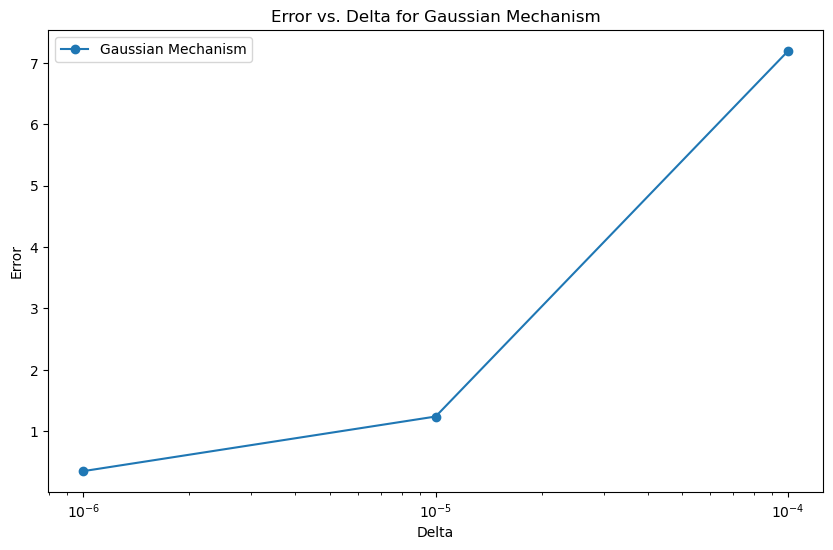

In [14]:
delta_values = [1e-4, 1e-5, 1e-6]
gaussian_delta_errors = []

for delta in delta_values:
    gaussian_result = gaussian_mech(true_mean, sensitivity, epsilon, delta)
    gaussian_delta_errors.append(abs(gaussian_result - true_mean))

# Plot delta vs. error
plt.figure(figsize=(10, 6))
plt.plot(delta_values, gaussian_delta_errors, marker='o', label='Gaussian Mechanism')
plt.xlabel('Delta')
plt.ylabel('Error')
plt.title('Error vs. Delta for Gaussian Mechanism')
plt.xscale('log') 
plt.legend()
plt.show()

### What it tells us:

This test investigates the effect of the delta parameter in the Gaussian mechanism. Delta controls the probability of exceeding a certain privacy guarantee, providing an additional lever for managing noise.

### Takeaway:

Smaller delta values result in stronger privacy but higher noise and errors. This test highlights how adjusting delta can fine-tune the balance between privacy and accuracy in Gaussian mechanisms.

## 7. Comparison Across Different Columns

### Objective
Evaluate how the mechanisms perform on different data types (e.g., numeric vs. categorical).

#### Procedure
1. Apply mechanisms to various columns (e.g., GPA, student ID).
2. Compare errors for different column types.



In [16]:
columns_to_test = ['GPA', 'StudentID']
errors_per_column = {}

for column in columns_to_test:
    column_mean = students_data[column].mean() if students_data[column].dtype in ['float64', 'int64'] else 0
    laplace_result = laplace_mech(column_mean, sensitivity, epsilon)
    gaussian_result = gaussian_mech(column_mean, sensitivity, epsilon, delta)
    laplace_error = abs(laplace_result - column_mean)
    gaussian_error = abs(gaussian_result - column_mean)
    errors_per_column[column] = {'Laplace': laplace_error, 'Gaussian': gaussian_error}


errors_per_column

{'GPA': {'Laplace': 0.32839307478283297, 'Gaussian': 4.691691165491756},
 'StudentID': {'Laplace': 0.03595587128165789, 'Gaussian': 9.09270213729451}}

### What it tells us:

By applying both mechanisms to different data types (e.g., numerical vs. categorical), this test evaluates their effectiveness and impact across various dataset columns.

### Takeaway:

Numerical data (like GPA) is generally easier to handle with differential privacy than categorical data (like IDs or emails). This test helps determine whether certain columns require different privacy mechanisms or parameter tuning.

## 8. Privacy-Accuracy Tradeoff Visualization

### Objective
Visualize the trade-off between privacy and accuracy by varying epsilon.

#### Procedure
1. Plot error curves for different epsilon values.
2. Compare the trade-off for both mechanisms.



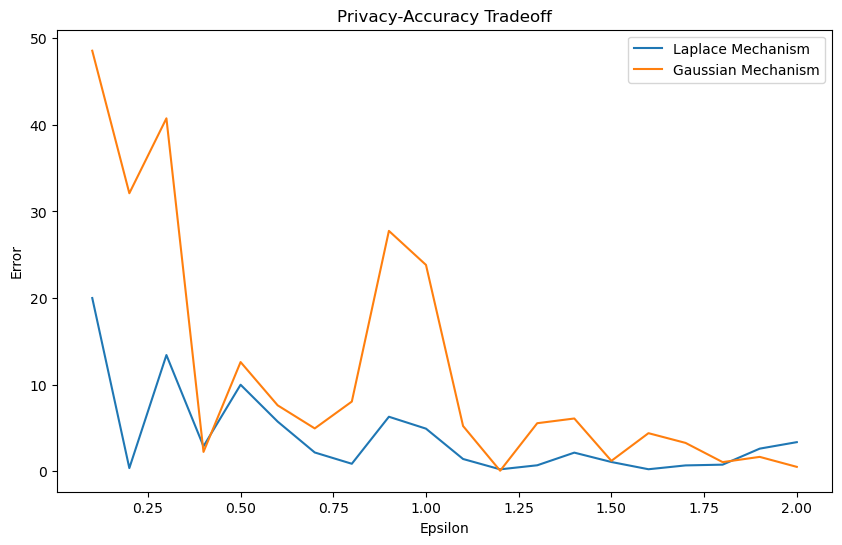

In [17]:
epsilon_values = np.linspace(0.1, 2.0, 20)
laplace_errors = []
gaussian_errors = []

for epsilon in epsilon_values:
    laplace_result = laplace_mech(true_mean, sensitivity, epsilon)
    gaussian_result = gaussian_mech(true_mean, sensitivity, epsilon, delta)
    laplace_errors.append(abs(laplace_result - true_mean))
    gaussian_errors.append(abs(gaussian_result - true_mean))


plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, laplace_errors, label='Laplace Mechanism')
plt.plot(epsilon_values, gaussian_errors, label='Gaussian Mechanism')
plt.xlabel('Epsilon')
plt.ylabel('Error')
plt.title('Privacy-Accuracy Tradeoff')
plt.legend()
plt.show()

### What it tells us:

This test visualizes how changing epsilon affects the balance between privacy and accuracy. A smaller epsilon provides greater privacy but introduces more error.

### Takeaway:

The visualization clearly illustrates the tradeoff, helping stakeholders make informed decisions about the appropriate level of privacy for their use case. It emphasizes the differences between Laplace and Gaussian mechanisms in balancing this tradeoff.

## 9. Differential Privacy for Missing Data

### Objective
Test mechanism performance with missing data (NaNs).

#### Procedure
1. Introduce NaNs in key columns.
2. Apply privacy mechanisms and analyze their robustness.



In [19]:
gpa_with_nans = gpa_column.copy()
gpa_with_nans.iloc[:10] = np.nan  # Add NaNs to the first 10 rows


gpa_filled = gpa_with_nans.fillna(gpa_column.mean())


laplace_with_nans = laplace_mech(gpa_filled.mean(), sensitivity, epsilon)
gaussian_with_nans = gaussian_mech(gpa_filled.mean(), sensitivity, epsilon, delta)

laplace_error_with_nans = abs(laplace_with_nans - gpa_filled.mean())
gaussian_error_with_nans = abs(gaussian_with_nans - gpa_filled.mean())

print("Error with Missing Data - Laplace:", laplace_error_with_nans)
print("Error with Missing Data - Gaussian:", gaussian_error_with_nans)

Error with Missing Data - Laplace: 1.99175586282372
Error with Missing Data - Gaussian: 5.39515600692191


### What it tells us:

This test evaluates how missing or incomplete data impacts the performance of differential privacy mechanisms. Missing data can alter the sensitivity of queries and the distribution of results.

### Takeaway:

Mechanisms that can handle missing data gracefully are more robust and practical for real-world datasets. This test reveals how Laplace and Gaussian mechanisms are affected by missing values and which one is more reliable in such scenarios.